In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

data_dir = '/tmp/tfds'
data, info = tfds.load(name="mnist",
    data_dir=data_dir,
    as_supervised=True,
    with_info=True)

data_train = data['train']
data_test = data['test']

2024-10-15 05:52:23.232886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 05:52:23.294558: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 05:52:23.308873: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 05:52:23.382675: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 05:52:24.883513: W tensorflow/compiler/tf2

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /tmp/tfds/mnist/3.0.1. Subsequent calls will reuse this data.


I0000 00:00:1728985949.238415   16974 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-15 05:52:29.430538: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2024-10-15 05:54:18.219083: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-15 05:54:18.221022: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


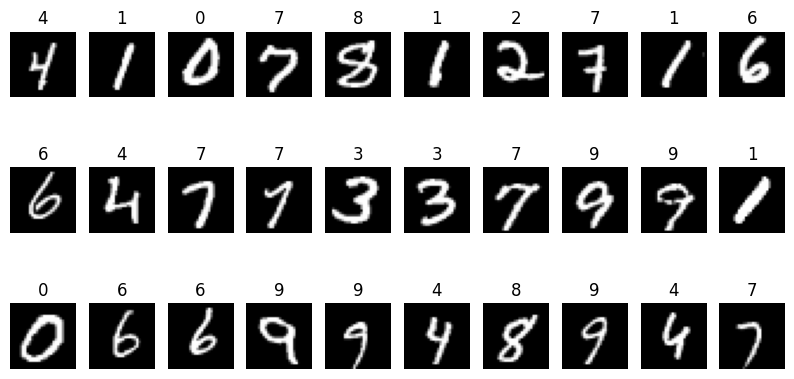

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]

ROWS = 3
COLS = 10

i = 0
fig, ax = plt.subplots(ROWS, COLS)

for image, label in data_train.take(ROWS*COLS):
    ax[int(i/COLS), i%COLS].axis('off')
    
    ax[int(i/COLS), i%COLS].set_title(str(label.numpy()))
    
    ax[int(i/COLS), i%COLS].imshow(np.reshape(image, (28,28)), cmap='gray')
    i += 1
    
plt.show()

In [3]:
HEIGHT = 28
WIDTH  = 28
CHANNELS = 1
NUM_PIXELS = HEIGHT * WIDTH * CHANNELS
NUM_LABELS = info.features['label'].num_classes

In [4]:
import jax.numpy as jnp

In [5]:
def preprocess(img, label):
  """Resize and preprocess images."""
  return (tf.cast(img, tf.float32)/255.0), label

In [6]:
data_train_vis = data_train.map(preprocess)
     

2024-10-15 05:59:33.329564: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-15 05:59:33.331067: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


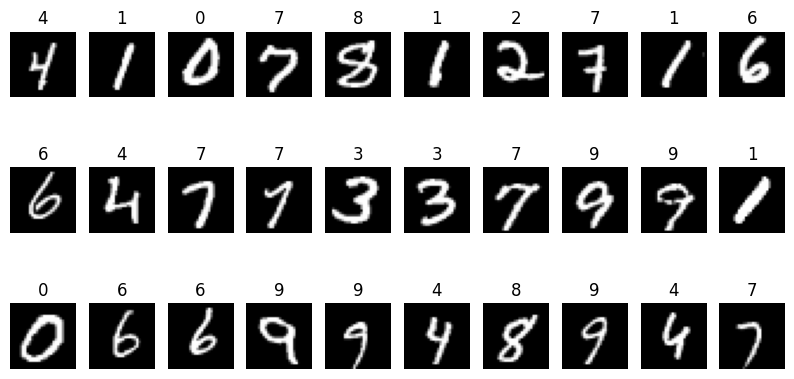

In [7]:
i = 0
fig, ax = plt.subplots(ROWS, COLS)
for image, label in data_train_vis.take(ROWS*COLS):
    ax[int(i/COLS), i%COLS].axis('off')
    ax[int(i/COLS), i%COLS].set_title(str(label.numpy()))
    ax[int(i/COLS), i%COLS].imshow(np.reshape(image, (28,28)), cmap='gray')
    i += 1

plt.show()

In [8]:
train_data = tfds.as_numpy(data_train.map(preprocess).batch(32).prefetch(1))
test_data  = tfds.as_numpy(data_test.map(preprocess).batch(32).prefetch(1))

In [9]:
LAYER_SIZES = [28*28, 512, 10]
PARAM_SCALE = 0.01

In [10]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.nn import swish, logsumexp, one_hot

In [11]:
def init_network_params(sizes, key=random.PRNGKey(0), scale=1e-2):
  """Initialize all layers for a fully-connected neural network with given sizes"""

  def random_layer_params(m, n, key, scale=1e-2):
    """A helper function to randomly initialize weights and biases of a dense layer"""
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k, scale) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

In [12]:
params = init_network_params(LAYER_SIZES, random.PRNGKey(0), scale=PARAM_SCALE)

In [13]:
def predict(params, image):
  """Function for per-example predictions."""
  activations = image
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = swish(outputs)

  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits     

In [14]:
random_flattened_image = random.normal(random.PRNGKey(1), (28*28*1,))
preds = predict(params, random_flattened_image)
print(preds.shape)

(10,)


In [15]:
random_flattened_images = random.normal(random.PRNGKey(1), (32, 28*28*1))
try:
  preds = predict(params, random_flattened_images)
except TypeError as e:
  print(e)

dot_general requires contracting dimensions to have the same shape, got (784,) and (32,).


In [16]:
batched_predict = vmap(predict, in_axes=(None, 0))

In [17]:
# `batched_predict` has the same call signature as `predict`
batched_preds = batched_predict(params, random_flattened_images)
print(batched_preds.shape)

(32, 10)


In [18]:
jax.devices()

[CudaDevice(id=0)]

In [19]:
INIT_LR = 1.0
DECAY_RATE = 0.95
DECAY_STEPS = 5

In [20]:
def loss(params, images, targets):
  """Categorical cross entropy loss function."""
  logits = batched_predict(params, images)
  log_preds = logits - logsumexp(logits) # logsumexp trick https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
  return -jnp.mean(targets*log_preds)

@jit
def update(params, x, y, epoch_number):
  loss_value, grads = value_and_grad(loss)(params, x, y)
  lr = INIT_LR * DECAY_RATE ** (epoch_number / DECAY_STEPS)
  return [(w - lr * dw, b - lr * db)
          for (w, b), (dw, db) in zip(params, grads)], loss_value

In [21]:
num_epochs = 25

In [22]:
@jit
def batch_accuracy(params, images, targets):
  images = jnp.reshape(images, (len(images), NUM_PIXELS))
  predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
  return jnp.mean(predicted_class == targets)

def accuracy(params, data):
  accs = []
  for images, targets in data:
    accs.append(batch_accuracy(params, images, targets))
  return jnp.mean(jnp.array(accs))

import time

for epoch in range(num_epochs):
  start_time = time.time()
  losses = []
  for x, y in train_data:
    x = jnp.reshape(x, (len(x), NUM_PIXELS))
    y = one_hot(y, NUM_LABELS)
    params, loss_value = update(params, x, y, epoch)
    losses.append(loss_value)
  epoch_time = time.time() - start_time

  start_time = time.time()
  train_acc = accuracy(params, train_data)
  test_acc = accuracy(params, test_data)
  eval_time = time.time() - start_time
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Eval in {:0.2f} sec".format(eval_time))
  print("Training set loss {}".format(jnp.mean(jnp.array(losses))))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

2024-10-15 06:06:43.797622: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 0 in 3.12 sec
Eval in 2.77 sec
Training set loss 0.41040700674057007
Training set accuracy 0.9299499988555908
Test set accuracy 0.931010365486145


2024-10-15 06:06:48.987646: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1 in 1.62 sec
Eval in 1.85 sec
Training set loss 0.37730318307876587
Training set accuracy 0.9500166773796082
Test set accuracy 0.9497803449630737
Epoch 2 in 1.75 sec
Eval in 1.89 sec
Training set loss 0.3708733022212982
Training set accuracy 0.9603500366210938
Test set accuracy 0.9593650102615356
Epoch 3 in 1.77 sec
Eval in 1.78 sec
Training set loss 0.3674818277359009
Training set accuracy 0.9666333198547363
Test set accuracy 0.9640575051307678


2024-10-15 06:07:00.260623: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4 in 1.76 sec
Eval in 1.81 sec
Training set loss 0.3651924729347229
Training set accuracy 0.9704166650772095
Test set accuracy 0.9673522114753723
Epoch 5 in 1.62 sec
Eval in 1.84 sec
Training set loss 0.36349740624427795
Training set accuracy 0.9737333655357361
Test set accuracy 0.9694488644599915
Epoch 6 in 1.74 sec
Eval in 2.12 sec
Training set loss 0.36217668652534485
Training set accuracy 0.9761999845504761
Test set accuracy 0.9710463285446167
Epoch 7 in 1.79 sec
Eval in 2.03 sec
Training set loss 0.36110663414001465
Training set accuracy 0.978516697883606
Test set accuracy 0.9734424948692322
Epoch 8 in 1.75 sec
Eval in 1.99 sec
Training set loss 0.36021512746810913
Training set accuracy 0.9803000092506409
Test set accuracy 0.9747403860092163


2024-10-15 06:07:20.996029: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9 in 1.81 sec
Eval in 1.81 sec
Training set loss 0.35945671796798706
Training set accuracy 0.982200026512146
Test set accuracy 0.9754392504692078
Epoch 10 in 1.73 sec
Eval in 1.91 sec
Training set loss 0.35880008339881897
Training set accuracy 0.9835500121116638
Test set accuracy 0.976138174533844
Epoch 11 in 1.62 sec
Eval in 1.82 sec
Training set loss 0.3582228422164917
Training set accuracy 0.9847000241279602
Test set accuracy 0.9768370389938354
Epoch 12 in 1.75 sec
Eval in 1.89 sec
Training set loss 0.35770878195762634
Training set accuracy 0.9854833483695984
Test set accuracy 0.9776357412338257
Epoch 13 in 1.74 sec
Eval in 1.84 sec
Training set loss 0.35724619030952454
Training set accuracy 0.9863499999046326
Test set accuracy 0.9782348275184631
Epoch 14 in 1.79 sec
Eval in 1.87 sec
Training set loss 0.35682618618011475
Training set accuracy 0.9873999953269958
Test set accuracy 0.9789336919784546
Epoch 15 in 1.75 sec
Eval in 1.81 sec
Training set loss 0.35644233226776123
Trai

2024-10-15 06:08:03.853446: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 20 in 1.75 sec
Eval in 1.87 sec
Training set loss 0.35491806268692017
Training set accuracy 0.990850031375885
Test set accuracy 0.9806309938430786
Epoch 21 in 1.78 sec
Eval in 1.83 sec
Training set loss 0.3546726703643799
Training set accuracy 0.9912333488464355
Test set accuracy 0.9808306694030762
Epoch 22 in 1.74 sec
Eval in 1.90 sec
Training set loss 0.35444244742393494
Training set accuracy 0.9916833639144897
Test set accuracy 0.980930507183075
Epoch 23 in 1.76 sec
Eval in 1.91 sec
Training set loss 0.35422590374946594
Training set accuracy 0.9921666979789734
Test set accuracy 0.9811301827430725
Epoch 24 in 1.72 sec
Eval in 1.80 sec
Training set loss 0.354021817445755
Training set accuracy 0.9924833178520203
Test set accuracy 0.9812300205230713


In [23]:
import pickle

In [24]:
model_weights_file = 'mlp_weights.pickle'

In [25]:
with open(model_weights_file, 'wb') as file:
    pickle.dump(params, file)

In [26]:
with open(model_weights_file, 'rb') as file:
    restored_params = pickle.load(file)

In [27]:
def pytree_compare(tree1, tree2):
    structure_equal = jax.tree_util.tree_flatten(tree1)[1] == jax.tree_util.tree_flatten(tree2)[1]
    entries_equal = np.all(jax.tree_util.tree_flatten(jax.tree_util.tree_map(np.array_equal, tree1, tree2))[0])
    return structure_equal and entries_equal

In [28]:
pytree_compare(params, restored_params)

True

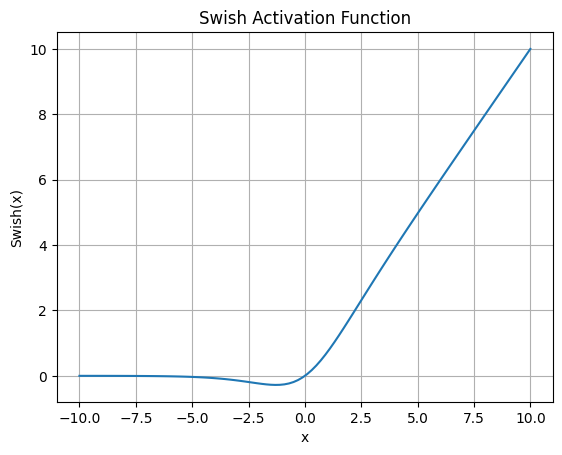

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def swish(x):
    return x * sigmoid(x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.linspace(-10, 10, 100)
y = swish(x)

plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('Swish(x)')
plt.title('Swish Activation Function')
plt.grid(True)
plt.show()